In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
!gdown --id 17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X
From (redirected): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X&confirm=t&uuid=0e12f0b0-05df-4057-93ad-c7fd9dde6cd5
To: /content/dataset.zip
100% 81.0M/81.0M [00:02<00:00, 34.6MB/s]


In [3]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
# Set the dataset folder path
dataset_folder = 'dataset'

# Get the list of class folders
class_folders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# Create lists to store the image file paths and their corresponding labels
image_files = []
labels = []

# Iterate through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)
    image_files_in_class = [os.path.join(class_folder_path, f) for f in os.listdir(class_folder_path) if f.endswith('.jpg')]
    image_files.extend(image_files_in_class)
    labels.extend([class_folder] * len(image_files_in_class))

# Convert the lists to numpy arrays
image_files = np.array(image_files)
labels = np.array(labels)

# Split the data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.3, random_state=42, stratify=labels)

# Create train and test folders if they don't exist
if not os.path.exists(os.path.join(dataset_folder, 'train')):
    os.makedirs(os.path.join(dataset_folder, 'train'))
if not os.path.exists(os.path.join(dataset_folder, 'test')):
    os.makedirs(os.path.join(dataset_folder, 'test'))

# Move images to train and test folders
for file in train_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'train', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'train', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'train', class_folder, os.path.basename(file)))

for file in test_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'test', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'test', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'test', class_folder, os.path.basename(file)))

In [5]:
train_dir = "dataset/train"
test_dir = "dataset/test"

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 339 images belonging to 64 classes.
Found 146 images belonging to 64 classes.


In [6]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 339
Testing samples: 146


In [ ]:
print("Class Indicate", train_generator.class_indices)

In [7]:
# Create a MirroredStrategy to use both GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

# Compile the model under the MirroredStrategy
with mirrored_strategy.scope():
    # Load pre-trained Resnet model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    train_generator.class_weights = class_weights
    test_generator.class_weights = class_weights

    # Define the model architecture
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(len(classes_train), activation='softmax')(x)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])


    # Define early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001)

    # Train the model
    history = model.fit(train_generator,
                        epochs=100,
                        batch_size=32,
                        validation_data=test_generator,
                        callbacks=[early_stopping],
                        verbose=1)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
11/11 [==============================] - 18s 639ms/step - loss: 4.3716 - accuracy: 0.0796 - val_loss: 3.6104 - val_accuracy: 0.1027
Epoch 2/100
11/11 [==============================] - 8s 729ms/step - loss: 2.2873 - accuracy: 0.3982 - val_loss: 3.0274 - val_accuracy: 0.2055
Epoch 3/100
11/11 [==============================] - 7s 635ms/step - loss: 1.4568 - accuracy: 0.6106 - val_loss: 2.4887 - val_accuracy: 0.3973
Epoch 4/100
11/11 [==============================] - 7s 597ms/step - loss: 0.9453 - accuracy: 0.7788 - val_loss: 2.1405 - val_accuracy: 0.5205
Epoch 5/100
11/11 [==============================] - 10s 944ms/step - loss: 0.7467 - accuracy: 0.8260 - val_loss: 1.9307 - val_accuracy: 0.5411
Epoch 6/100
11/11 [==============================] - 8s 704ms/step - loss: 0.5978 - accuracy: 0.8584 - val_loss: 1.7613 - val_accuracy: 0.6164
Epoch 7/100
11/11 [==============================] - 6s 615ms/step - loss: 0.

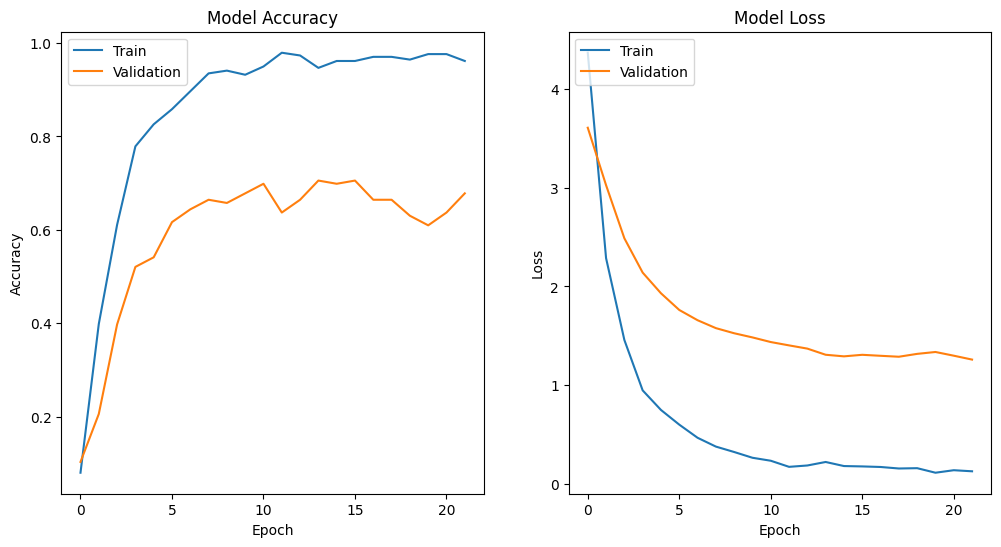

In [8]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Saving images.jpeg to images.jpeg
User uploaded file "images.jpeg" with length 7674 bytes
1/1 [==============================] - 0s 78ms/step


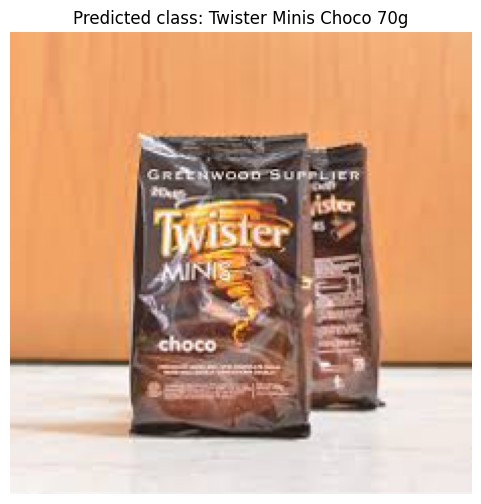

In [14]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [15]:
#save your model in the SavedModel format
export_dir = 'mobilenetv2/saved_model'
tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model.
with open('mobilenetv2_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [16]:
!zip -r mobilenetv2.zip mobilenetv2/

  adding: mobilenetv2/ (stored 0%)
  adding: mobilenetv2/saved_model/ (stored 0%)
  adding: mobilenetv2/saved_model/saved_model.pb (deflated 91%)
  adding: mobilenetv2/saved_model/fingerprint.pb (stored 0%)
  adding: mobilenetv2/saved_model/assets/ (stored 0%)
  adding: mobilenetv2/saved_model/variables/ (stored 0%)
  adding: mobilenetv2/saved_model/variables/variables.index (deflated 77%)
  adding: mobilenetv2/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


In [19]:
!mv mobilenetv2_model.tflite  /content/drive/MyDrive/model/